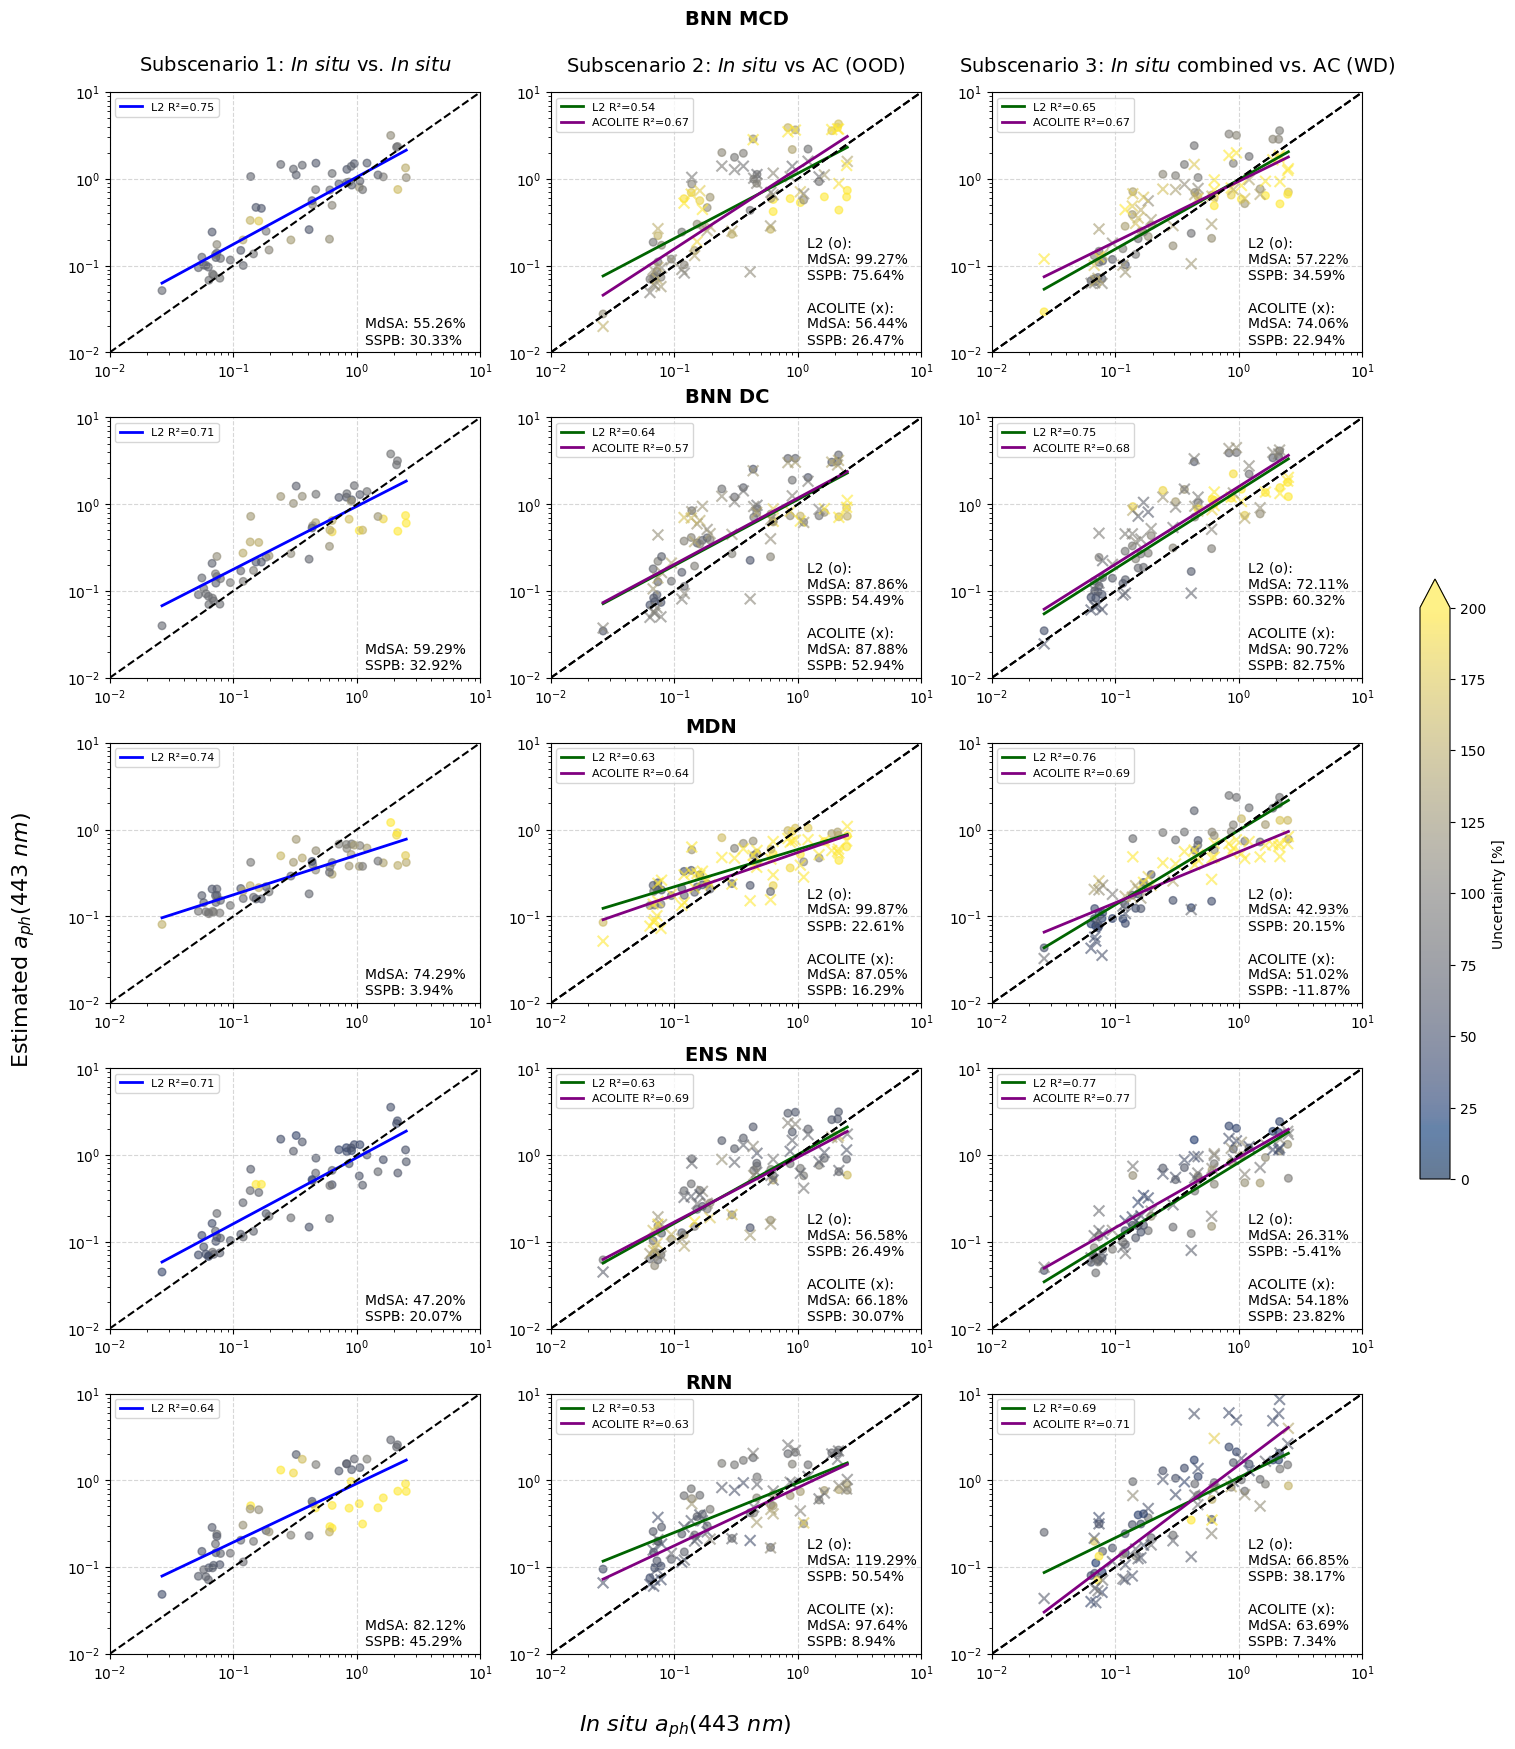

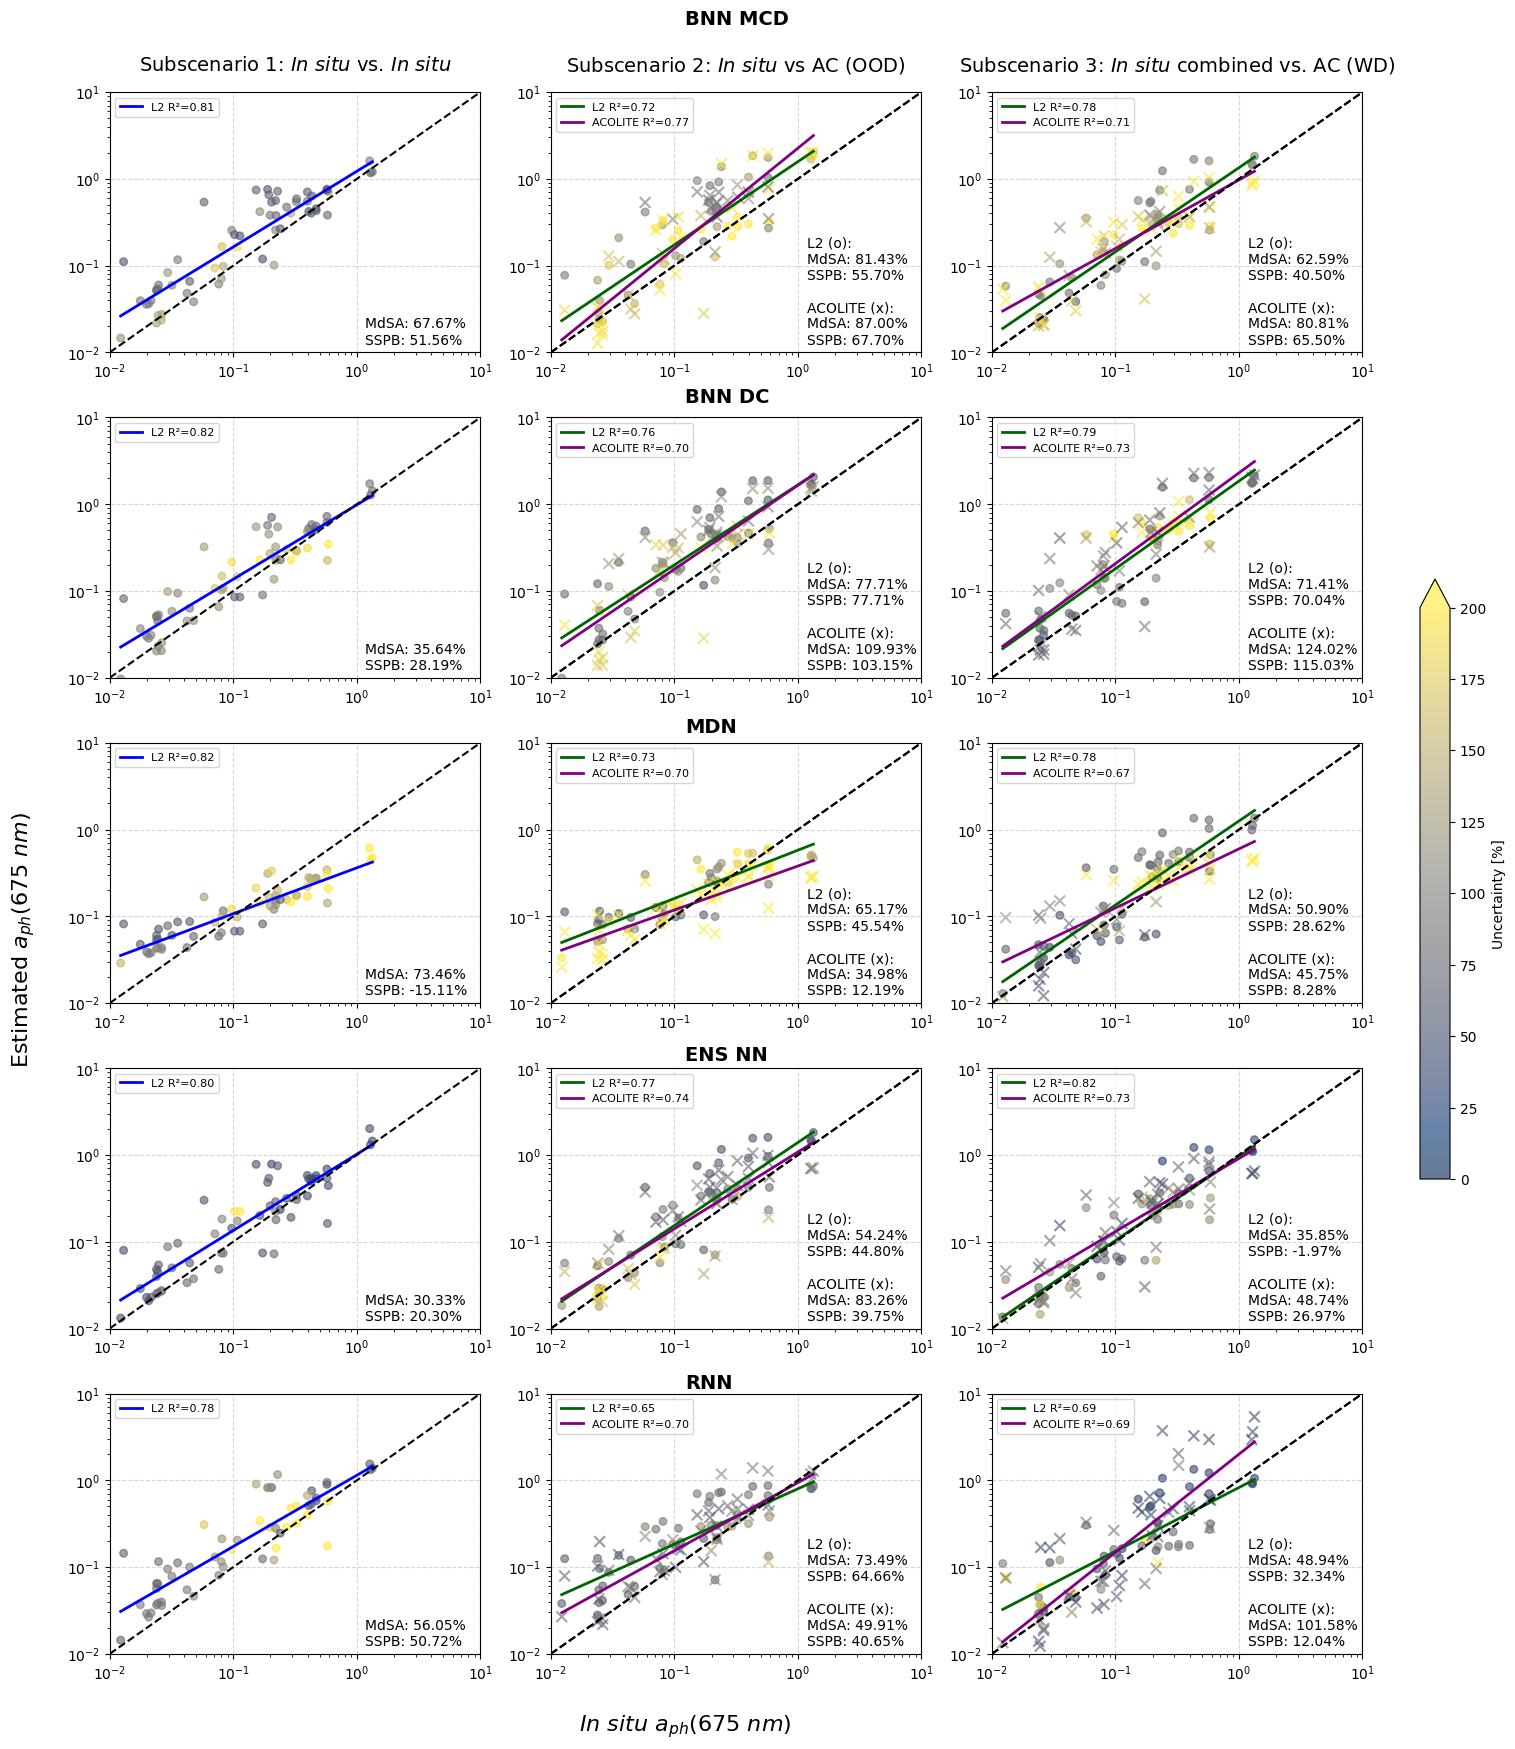

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import linregress

def mdsa(y, y_hat):
    ''' Median Symmetric Accuracy '''
    return 100 * (np.exp(np.median(np.abs(np.log(y_hat / y)))) - 1)

def sspb(y, y_hat):
    ''' Symmetric Signed Percentage Bias '''
    M = np.median(np.log(y_hat / y))
    return 100 * np.sign(M) * (np.exp(np.abs(M)) - 1)

def get_median_model(file_path):
    df = pd.read_csv(file_path)
    vars_443 = ['aph_443', 'aCDOM_443', 'aNAP_443']
    df_443 = df[df['variable'].isin(vars_443)]
    sum_mdsa_443 = df_443.groupby('model')['MdSA'].sum().sort_values()
    median_model = sum_mdsa_443.index[len(sum_mdsa_443) // 2]
    return median_model

def load_data(folder, scenario, model, variable):
    file_path = os.path.join(folder, f"{model}_prisma_{scenario}_estimates.csv")
    df = pd.read_csv(file_path)
    
    y_pred_df = df[df['category'] == 'y_pred']
    nan_instances = y_pred_df[y_pred_df[variable].isna()]['instance'].tolist()
    df_filtered = df[~df['instance'].isin(nan_instances)]
    
    y_true = df_filtered[df_filtered['category'] == 'y_true'][variable].values
    y_pred = df_filtered[df_filtered['category'] == 'y_pred'][variable].values
    total_var = df_filtered[df_filtered['category'] == 'total_var'][variable].values
    
    percent_total_uncertainty = (np.sqrt(total_var) / y_pred) * 100
    return y_true, y_pred, percent_total_uncertainty

def plot_scenario(ax, y_true, y_pred, percent_total_uncertainty, title, marker='o', color='blue', size=30, label=''):
    norm = plt.Normalize(vmin=0, vmax=200)
    sc = ax.scatter(y_true, y_pred, c=percent_total_uncertainty, cmap='cividis',
                    norm=norm, s=size, alpha=0.6, marker=marker)
    
    slope, intercept, r_value, _, _ = linregress(np.log(y_true), np.log(y_pred))
    x_reg = np.linspace(min(y_true), max(y_true), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color=color, lw=2, label=f'{label} R²={r_value**2:.2f}')
    
    mdsa_value = mdsa(y_true, y_pred)
    sspb_value = sspb(y_true, y_pred)
    metrics = f'MdSA: {mdsa_value:.2f}%\nSSPB: {sspb_value:.2f}%'
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-2, 10)
    ax.set_ylim(1e-2, 10)
    ax.grid(True, ls='--', alpha=0.5)
    ax.legend(fontsize=8)
    
    limits = [1e-2, 10]
    ax.plot(limits, limits, ls='--', color='black', linewidth=1.5)
    
    return sc, metrics

def create_plot(variable):
    fig, axs = plt.subplots(5, 3, figsize=(15, 20))

    parent_dir = 'C:/SwitchDrive/Data/pnn_model_estimates'
    models = ['bnn_mcd', 'bnn_dc', 'mdn', 'ens_nn', 'rnn']
    scenarios = ['1', 'ood', 'wd']

    norm = Normalize(vmin=0, vmax=200)

    if variable == 'aph_443':
        y_label = r'Estimated $a_{ph}(443\ nm)$'
        x_label = r'$In\ situ$ $a_{ph}(443\ nm)$'
    elif variable == 'aph_675':
        y_label = r'Estimated $a_{ph}(675\ nm)$'
        x_label = r'$In\ situ$ $a_{ph}(675\ nm)$'
    else:
        y_label = f'Estimated ${variable}$'
        x_label = f'$In\ situ$ ${variable}$'

    fig.supylabel(y_label, fontsize=16, x=0.05)
    fig.supxlabel(x_label, fontsize=16, y=0.1)

    column_titles = ['Subscenario 1: $\\it{In\ situ}$ vs. $\\it{In\ situ}$', 
                     'Subscenario 2: $\\it{In\ situ}$ vs AC (OOD)', 
                     'Subscenario 3: $\\it{In\ situ}$ combined vs. AC (WD)']
    for j, title in enumerate(column_titles):
        axs[0, j].set_title(title, fontsize=14, y=1.05)

    row_labels = {
        'BNN MCD': 0.96,
        'BNN DC': 0.771,
        'MDN': 0.606,
        'ENS NN': 0.442,
        'RNN': 0.278
    }
    for label, y_pos in row_labels.items():
        fig.text(0.5, y_pos, label.upper(), ha='left', va='center', fontsize=14, fontweight='bold')

    for i, model in enumerate(models):
        for j, scenario in enumerate(scenarios):
            metrics_file = f"{model}_prisma_{scenario if scenario == '1' else scenario + '_a'}_metrics.csv"
            metrics_path = os.path.join(parent_dir, metrics_file)
            median_model_num = get_median_model(metrics_path)
            
            folder = os.path.join(parent_dir, str(median_model_num))
            
            if scenario == '1':
                y_true, y_pred, percent_total_uncertainty = load_data(folder, '1', model, variable)
                sc, l2_metrics = plot_scenario(axs[i, j], y_true, y_pred, percent_total_uncertainty, 
                                               f'{model} - prisma_1 (Model {median_model_num})', 
                                               color='blue', size=30, label='L2')
                
                axs[i, j].text(0.69, 0.02, l2_metrics, transform=axs[i, j].transAxes, 
                               ha='left', va='bottom', fontsize=10,
                               bbox=dict(facecolor='none', edgecolor='none', alpha=0.7))
            else:
                y_true_a, y_pred_a, percent_total_uncertainty_a = load_data(folder, f'{scenario}_a', model, variable)
                y_true_l, y_pred_l, percent_total_uncertainty_l = load_data(folder, f'{scenario}_l', model, variable)
                
                sc, l2_metrics = plot_scenario(axs[i, j], y_true_a, y_pred_a, percent_total_uncertainty_a, 
                                               f'{model} - prisma_{scenario} (Model {median_model_num})', 
                                               marker='o', color='darkgreen', size=30, label='L2')
                _, aco_metrics = plot_scenario(axs[i, j], y_true_l, y_pred_l, percent_total_uncertainty_l, 
                                               f'{model} - prisma_{scenario} (Model {median_model_num})', 
                                               marker='x', color='purple', size=60, label='ACOLITE')
                
                axs[i, j].text(0.69, 0.02, f'L2 (o):\n{l2_metrics}\n\nACOLITE (x):\n{aco_metrics}',
                               transform=axs[i, j].transAxes, ha='left', va='bottom', fontsize=10,
                               bbox=dict(facecolor='none', edgecolor='none', alpha=0.7))
            
            axs[i, j].set_xlabel('')
            axs[i, j].set_ylabel('')

    plt.tight_layout(rect=[0.05, 0.1, 0.97, 0.95])
    plt.subplots_adjust(hspace=0.25)

    cbar_ax = fig.add_axes([0.99, 0.38, 0.02, 0.3])
    cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm, extend='max')
    cbar.set_label('Uncertainty [%]')

    #plt.savefig(f'C:/SwitchDrive/Data/Plots/{variable}_plot.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
create_plot('aph_443')
create_plot('aph_675')